In [2]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
Global seed set to 0


### Functions

In [5]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [6]:
meta = pd.read_csv('/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium/spaceranger/meta_visium.csv')


### Plot

In [7]:
adata_vis = sc.read_h5ad('/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium/allgene_epochs120/cell2location_map_inter/sp.h5ad')
#adata_vis = sc.read_h5ad('/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium/allgene_epochs120/cell2location_map_core/sp.h5ad')

In [8]:
adata_vis.obs['sample'].value_counts()

6800STDY12499406    3352
6800STDY12499508    2831
6800STDY12499509    2811
6800STDY12499502    2700
6800STDY12499504    2670
6800STDY12499503    2661
6800STDY12499505    2580
6800STDY12499507    2145
6800STDY12499409    2085
6800STDY12499411    2048
6800STDY12499506    2029
Name: sample, dtype: int64

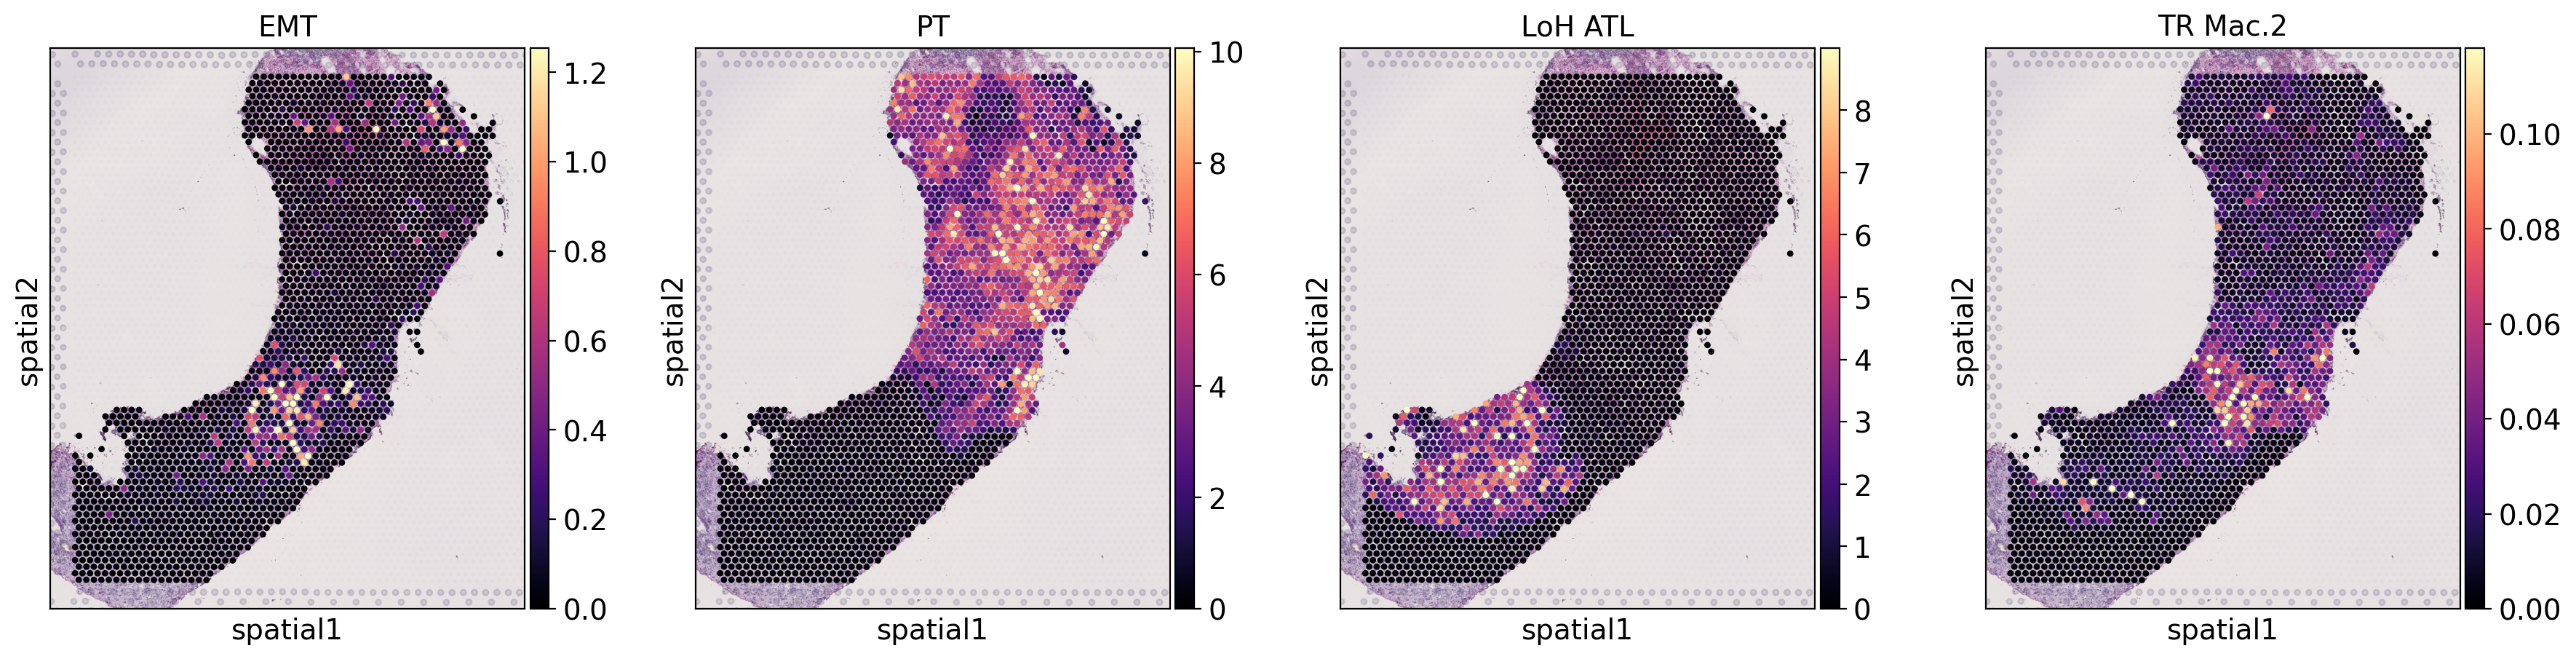

In [16]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, '6800STDY12499506')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['EMT', 'PT','LoH ATL','TR Mac.2'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

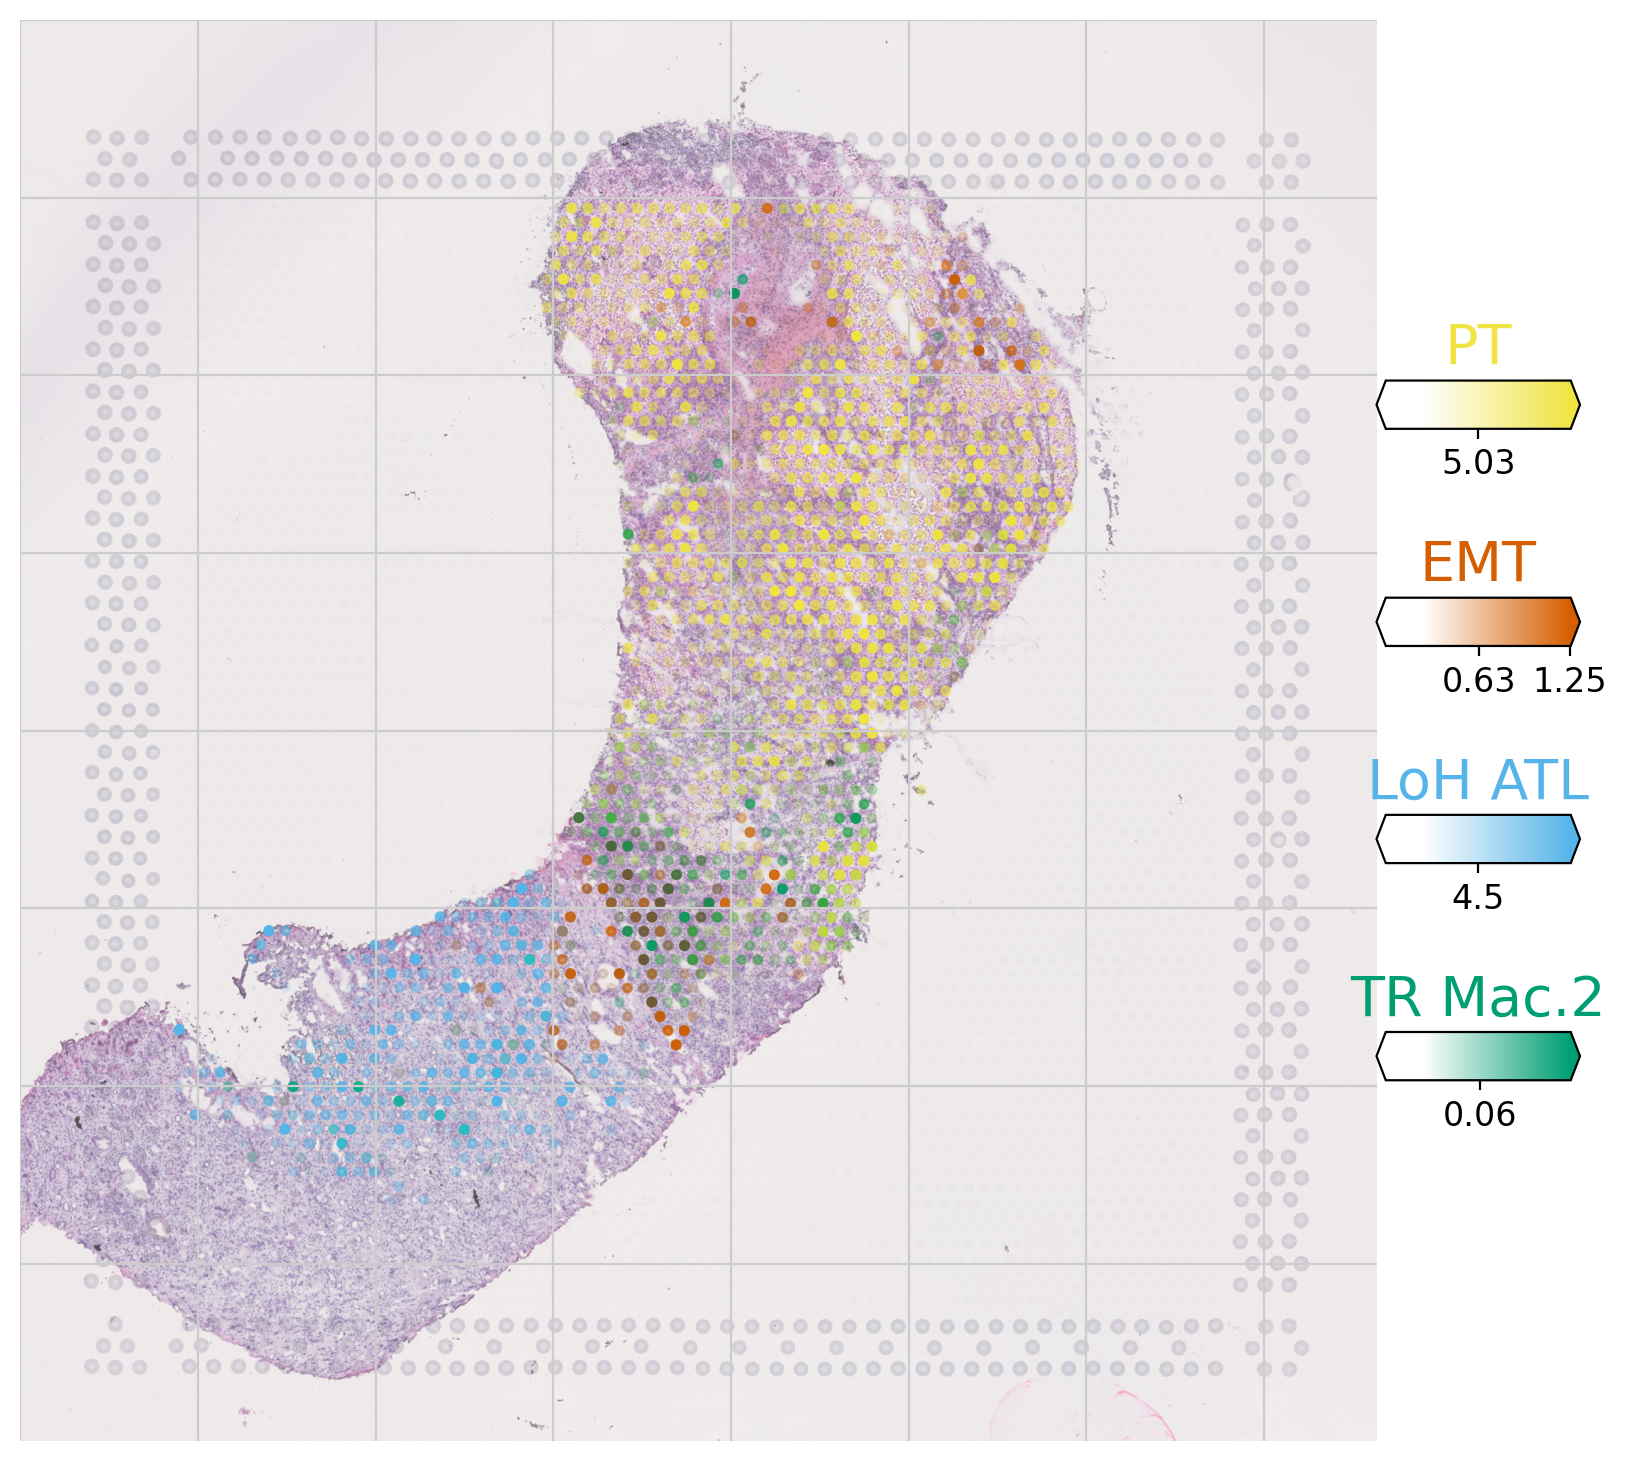

In [15]:
# select one slide
sc.settings.set_figure_params(dpi=100, facecolor='white')
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']
from cell2location.utils import select_slide
slide = select_slide(adata_vis, '6800STDY12499506')

from cell2location.plt import plot_spatial
with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=['PT', 'EMT', 'LoH ATL','TR Mac.2'], 
        labels=['PT', 'EMT', 'LoH ATL','TR Mac.2'],
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=3,
        colorbar_position='right',
        img_alpha = 0.7
    )
plt.savefig('/home/jovyan/figure1.1.pdf')